### Titanic Survival  -- Decision Tree Model

Here we will import data on Titanic passengers that either survived or died when the ship sank in 1912.  The Kaggle file train.csv will be used to develop the decision tree model and test.csv will be used to evaluate model performance. 

### Preliminaries
Load in the required library: recursive partitioning and import the training data from its origin .csv file into an R dataframe.  Inspect the contents of the data frame.

In [1]:
# Load the recursive partitioning module that will be used to generate decision tree.
library(rpart)

# Import train.csv into data frame
Titanic.train<-read.csv("Datasets/Titanic/train.csv", header=TRUE, sep=",")

# Report dimension of training dataframe
dim(Titanic.train)

# Show the top few lines of the training dataframe
head(Titanic.train)



[1] 891  12

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


In [2]:
# Cast Survived as factor/category levels from boolean vector
Titanic.train$Survived <- as.factor(Titanic.train$Survived)

# Cast Pclass as factor
Titanic.train$Pclass <- as.factor(Titanic.train$Pclass)

In [3]:
# Show how the training dataframe is structured
str(Titanic.train)

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


In [4]:
# Change levels of Survived and Embarked factors to more meaningful values...
levels(Titanic.train$Survived)<-c("Dead", "Survived")
levels(Titanic.train$Embarked)<-c("Unknown","Cherbourg", "Queenstown", "Southampton")

str(Titanic.train[,c('Survived','Embarked')])

'data.frame':	891 obs. of  2 variables:
 $ Survived: Factor w/ 2 levels "Dead","Survived": 1 2 2 2 1 1 1 1 2 2 ...
 $ Embarked: Factor w/ 4 levels "Unknown","Cherbourg",..: 4 2 4 4 4 3 4 4 4 2 ...


In [7]:
# Count the number of family members, including spouse, parents, children each passenger reported
Titanic.train$FamilySize <- Titanic.train$SibSp + Titanic.train$Parch

# Combine SibSp and Parch categories into simple yes/no for "HasFamily"
Titanic.train$HasFamily <- as.factor(Titanic.train$FamilySize > 0)

# Strip off room number from values in Cabin column to reduce number of levels for the category
Titanic.train$CabinType <- as.factor(substr(as.character(Titanic.train$Cabin),1,1))

# Make separate category to identify children
Titanic.train$IsChild <- as.factor(Titanic.train$Age <= 12)

# Make separate category to identify seniors
Titanic.train$IsSenior <- as.factor(Titanic.train$Age >= 50)

str(Titanic.train[,c("FamilySize", "HasFamily", "CabinType", "IsChild", "IsSenior")])

'data.frame':	891 obs. of  5 variables:
 $ FamilySize: int  1 1 0 1 0 0 0 4 2 1 ...
 $ HasFamily : Factor w/ 2 levels "FALSE","TRUE": 2 2 1 2 1 1 1 2 2 2 ...
 $ CabinType : Factor w/ 9 levels "","A","B","C",..: 1 4 1 4 1 1 6 1 1 1 ...
 $ IsChild   : Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 1 NA 1 2 1 1 ...
 $ IsSenior  : Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 1 NA 2 1 1 1 ...


In [8]:
# Examine summary statistics of the training data.
summary(Titanic.train)

  PassengerId        Survived   Pclass 
 Min.   :  1.0   Dead    :549   1:216  
 1st Qu.:223.5   Survived:342   2:184  
 Median :446.0                  3:491  
 Mean   :446.0                         
 3rd Qu.:668.5                         
 Max.   :891.0                         
                                       
                                    Name         Sex           Age       
 Abbing, Mr. Anthony                  :  1   female:314   Min.   : 0.42  
 Abbott, Mr. Rossmore Edward          :  1   male  :577   1st Qu.:20.12  
 Abbott, Mrs. Stanton (Rosa Hunt)     :  1                Median :28.00  
 Abelson, Mr. Samuel                  :  1                Mean   :29.70  
 Abelson, Mrs. Samuel (Hannah Wizosky):  1                3rd Qu.:38.00  
 Adahl, Mr. Mauritz Nils Martin       :  1                Max.   :80.00  
 (Other)                              :885                NA's   :177    
     SibSp           Parch             Ticket         Fare       
 Min.   :0.000   Min. 

### Build the model
Begin by randomly sampling training and testing subsets from this total training dataset.  We will use this to appraise the accuracy of the approach prior to incorporating the entire set of training data to build the decision tree.

In [9]:
train.index <- sample(1:nrow(Titanic.train), 0.7*nrow(Titanic.train))
Titanic.subtrain <- Titanic.train[train.index, ]
Titanic.subtest <- Titanic.train[-train.index, ]
str(Titanic.subtrain)
str(Titanic.subtest)

'data.frame':	623 obs. of  17 variables:
 $ PassengerId: int  586 813 851 545 170 111 499 11 754 576 ...
 $ Survived   : Factor w/ 2 levels "Dead","Survived": 2 1 1 1 1 1 1 2 1 1 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 1 2 3 1 3 1 1 3 3 3 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 803 768 23 227 491 672 19 732 420 644 ...
 $ Sex        : Factor w/ 2 levels "female","male": 1 2 2 2 2 2 1 1 2 2 ...
 $ Age        : num  18 35 4 50 28 47 25 4 23 19 ...
 $ SibSp      : int  0 0 4 1 0 0 1 1 0 0 ...
 $ Parch      : int  2 0 2 0 0 0 2 1 0 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 2 223 334 615 81 3 38 617 352 421 ...
 $ Fare       : num  79.7 10.5 31.3 106.4 56.5 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 137 1 1 84 1 54 64 147 1 1 ...
 $ Embarked   : Factor w/ 4 levels "Unknown","Cherbourg",..: 4 4 4 2 4 4 4 4 4 4 ...
 $ HasFamily  : Factor w/ 2 levels "FALSE","TRUE": 2 1 2 2 1 1 2 2 1 1 ...
 $ CabinType  : Factor w/ 

In [164]:
# Compute decision tree
titanic.tree<-rpart(Survived ~ Pclass + Sex + CabinType + FamilySize + 
                    Embarked + IsChild + IsSenior, 
                    data = Titanic.subtrain, 
                    method="class", parms=list(split="gini"),
                    control = rpart.control(minsplit = 10, minbucket = 5))

In [169]:
as.formula(titanic.tree)

Survived ~ Pclass + Sex + CabinType + FamilySize + Embarked + 
    IsChild + IsSenior
attr(,"variables")
list(Survived, Pclass, Sex, CabinType, FamilySize, Embarked, 
    IsChild, IsSenior)
attr(,"factors")
           Pclass Sex CabinType FamilySize Embarked IsChild IsSenior
Survived        0   0         0          0        0       0        0
Pclass          1   0         0          0        0       0        0
Sex             0   1         0          0        0       0        0
CabinType       0   0         1          0        0       0        0
FamilySize      0   0         0          1        0       0        0
Embarked        0   0         0          0        1       0        0
IsChild         0   0         0          0        0       1        0
IsSenior        0   0         0          0        0       0        1
attr(,"term.labels")
[1] "Pclass"     "Sex"        "CabinType"  "FamilySize" "Embarked"  
[6] "IsChild"    "IsSenior"  
attr(,"order")
[1] 1 1 1 1 1 1 1
attr(,"intercept")


In [170]:
titanic.tree

n= 623 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 623 245 Dead (0.60674157 0.39325843)  
   2) Sex=male 397  74 Dead (0.81360202 0.18639798)  
     4) CabinType=,A,T 336  47 Dead (0.86011905 0.13988095)  
       8) IsChild=FALSE 313  38 Dead (0.87859425 0.12140575) *
       9) IsChild=TRUE 23   9 Dead (0.60869565 0.39130435)  
        18) FamilySize>=4 14   1 Dead (0.92857143 0.07142857) *
        19) FamilySize< 4 9   1 Survived (0.11111111 0.88888889) *
     5) CabinType=B,C,D,E,F 61  27 Dead (0.55737705 0.44262295)  
      10) IsSenior=TRUE 14   2 Dead (0.85714286 0.14285714) *
      11) IsSenior=FALSE 47  22 Survived (0.46808511 0.53191489)  
        22) IsChild=FALSE 42  20 Dead (0.52380952 0.47619048)  
          44) CabinType=B,C,D,F 35  14 Dead (0.60000000 0.40000000)  
            88) Embarked=Queenstown,Southampton 21   5 Dead (0.76190476 0.23809524) *
            89) Embarked=Cherbourg 14   5 Survived (0.35714286 0.64285714) *
          45

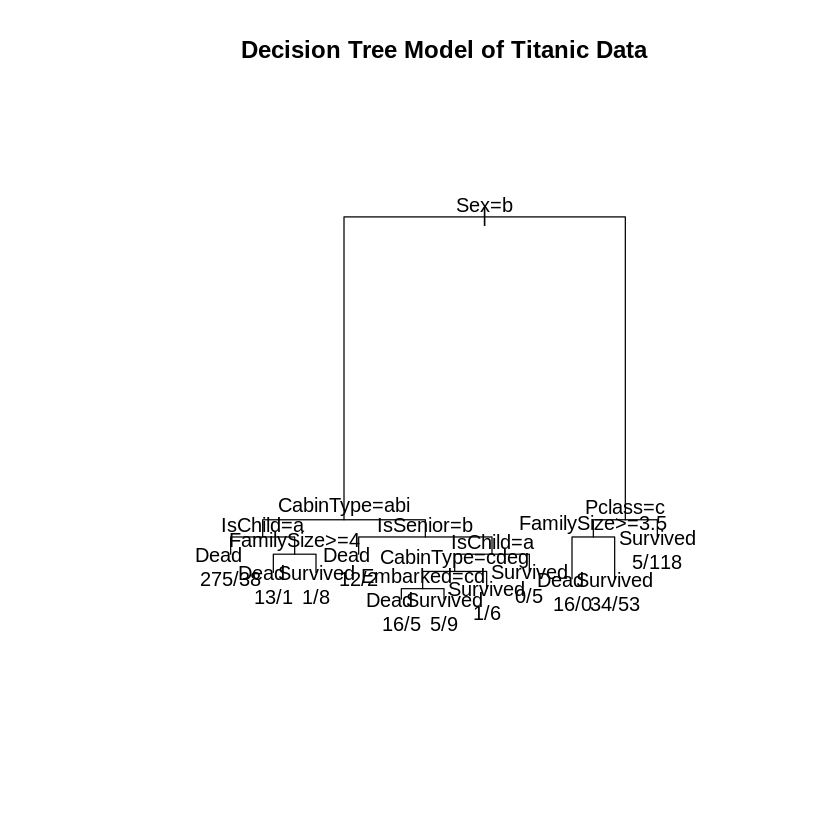

In [171]:
# Visualize the model
# Plot the tree structure
plot(titanic.tree, margin = c(0.25))
title(main = "Decision Tree Model of Titanic Data")
text(titanic.tree, use.n = TRUE)

In [172]:
# Predict survival of passengers in the the Titanic.subtest dataset using the decision model
Titanic.subtest.predictions <- predict(titanic.tree, Titanic.subtest, type="class")
head(Titanic.subtest.predictions)

3        4        6        8       13       14 
Survived Survived     Dead     Dead     Dead     Dead 
Levels: Dead Survived

In [173]:
# Predicted values can also be probabilities,instead of class labels
Titanic.subtest.predictions.prob <- predict(titanic.tree, Titanic.subtest, type = "prob")
head(Titanic.subtest.predictions.prob)

,Dead,Survived
3,0.39080460,0.60919540
4,0.04065041,0.95934959
6,0.87859425,0.12140575
8,0.92857143,0.07142857
13,0.87859425,0.12140575
14,0.87859425,0.12140575


In [174]:
# Comparison table of actual values and predicted values
Titanic.comparison <- Titanic.subtest
Titanic.comparison$Predictions <- Titanic.subtest.predictions
head(Titanic.comparison[ , c("Survived", "Predictions")])

,Survived,Predictions
3,Survived,Survived
4,Survived,Survived
6,Dead,Dead
8,Dead,Dead
13,Dead,Dead
14,Dead,Dead


In [175]:
# View misclassified rows
disagreement.index <- Titanic.comparison$Survived != Titanic.comparison$Predictions 
head(Titanic.comparison[disagreement.index, ])
sum(disagreement.index)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasFamily,CabinType,IsChild,IsSenior,FamilySize,Predictions
22,22,Survived,2,"Beesley, Mr. Lawrence",male,34,0,0,248698,13.0000,D56,Southampton,FALSE,D,FALSE,FALSE,0,Dead
24,24,Survived,1,"Sloper, Mr. William Thompson",male,28,0,0,113788,35.5000,A6,Southampton,FALSE,A,FALSE,FALSE,0,Dead
26,26,Survived,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)",female,38,1,5,347077,31.3875,,Southampton,TRUE,,FALSE,FALSE,6,Dead
37,37,Survived,3,"Mamee, Mr. Hanna",male,NA,0,0,2677,7.2292,,Cherbourg,FALSE,,NA,NA,0,Dead
41,41,Dead,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40,1,0,7546,9.4750,,Southampton,TRUE,,FALSE,FALSE,1,Survived
56,56,Survived,1,"Woolner, Mr. Hugh",male,NA,0,0,19947,35.5000,C52,Southampton,FALSE,C,NA,NA,0,Dead


[1] 51

In [176]:
# Build the confusion matrix
titanic.dt.confusion <- table(Titanic.comparison$Predictions, Titanic.subtest[,"Survived"])
print(titanic.dt.confusion)

          
           Dead Survived
  Dead      147       27
  Survived   24       70


In [177]:
# Accuracy
titanic.dt.accuracy <- sum(diag(titanic.dt.confusion)) / sum(titanic.dt.confusion)
cat("Accuracy: ", titanic.dt.accuracy)
# Precision
titanic.dt.precision <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[2,])
cat("\nPrecision: ", titanic.dt.precision)
# Recall
titanic.dt.recall <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[,2])
cat("\nRecall: ", titanic.dt.recall)
# F1 score
titanic.dt.F1 <- 2 * titanic.dt.precision * titanic.dt.recall / (titanic.dt.precision + titanic.dt.recall)
cat("\nF1-score: ", titanic.dt.F1)

Accuracy:  0.8097015
Precision:  0.7446809
Recall:  0.7216495
F1-score:  0.7329843

### Perform Bootstrap of Model

In [182]:
# Specify number of runs to repeat
nReps <- 100

# Initialize storage vectors
Accuracy.Vec <- vector("numeric", length=nReps)
Precision.Vec <- vector("numeric", length=nReps)
Recall.Vec <- vector("numeric", length=nReps)
F1_score.Vec <- vector("numeric", length=nReps)

# Repeat decsion tree generation and performance evaluation nReps times 
for (i in 1:nReps){
    
    # Split data into training and testing subsets
    train.index <- sample(1:nrow(Titanic.train), 0.7*nrow(Titanic.train))
    Titanic.subtrain <- Titanic.train[train.index, ]
    Titanic.subtest <- Titanic.train[-train.index, ]
    
    # Compute decision tree
    titanic.tree.2<-rpart(as.formula(titanic.tree), 
                    data = Titanic.subtrain, 
                    method="class", parms=list(split="gini"),
                    control = rpart.control(minsplit = 10, minbucket=5))
    
    # Make predictions on current test set
    Titanic.subtest.predictions <- predict(titanic.tree.2, Titanic.subtest, type="class")

    # Comparison table of actual values and predicted values
    Titanic.comparison <- Titanic.subtest
    Titanic.comparison$Predictions <- Titanic.subtest.predictions
    
    # Build the confusion matrix of current run
    titanic.dt.confusion <- table(Titanic.comparison$Predictions, Titanic.subtest[,"Survived"])

    # Store accuracy of current run
    Accuracy.Vec[i] <- sum(diag(titanic.dt.confusion)) / sum(titanic.dt.confusion)
    
    # Store precision of current run
    Precision.Vec[i] <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[2,])
    
    # Store recall of current run
    Recall.Vec[i] <- titanic.dt.confusion[2,2] / sum(titanic.dt.confusion[,2])

    # Store F1 score of current run
    F1_score.Vec[i] <- 2 * Precision.Vec[i] * Recall.Vec[i] / (Precision.Vec[i] + Recall.Vec[i])
}

# Report summary stats
cat("\nAccuracy stats:")
summary(Accuracy.Vec)

cat("\nPrecision stats:")
summary(Precision.Vec)

cat("\nRecall stats:")
summary(Recall.Vec)

cat("\nF1-score stats:")
summary(F1_score.Vec)




Accuracy stats:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7687  0.8022  0.8134  0.8122  0.8209  0.8619 


Precision stats:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6809  0.7527  0.7807  0.7955  0.8392  0.9692 


Recall stats:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4742  0.6529  0.7067  0.6982  0.7555  0.8163 


F1-score stats:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6093  0.7218  0.7407  0.7391  0.7617  0.8098 

### Generate Complete Model and Make Predictions on Test Set

In [189]:
# Generate decision tree model using the full set of training data from train.csv
titanic.tree.fullset<-rpart(as.formula(titanic.tree), 
                    data = Titanic.train, 
                    method="class", parms=list(split="gini"),
                    control = rpart.control(minsplit = 10, minbucket=5))

# Import train.csv into data frame, this is our test data for which the actual survived labels are unknown.
Titanic.test<-read.csv("Datasets/Titanic/test.csv", header=TRUE, sep=",")

# Make same modifications to Titanic.test that were made to Titanic.train above (except for "survived" column)
#Titanic.test$Survived <- as.factor(Titanic.test$Survived)
Titanic.test$Pclass <- as.factor(Titanic.test$Pclass)
#levels(Titanic.test$Survived)<-c("Dead", "Survived")
levels(Titanic.test$Embarked)<-c("Unknown","Cherbourg", "Queenstown", "Southampton")
Titanic.test$FamilySize <- Titanic.test$SibSp + Titanic.test$Parch
Titanic.test$HasFamily <- as.factor(Titanic.test$FamilySize > 0)
Titanic.test$CabinType <- as.factor(substr(as.character(Titanic.test$Cabin),1,1))
Titanic.test$IsChild <- as.factor(Titanic.test$Age <= 12)
Titanic.test$IsSenior <- as.factor(Titanic.test$Age >= 50)


# Produce predictions using complete decision tree
Titanic.test.predictions <- predict(titanic.tree.fullset, Titanic.test, type="class")
head(Titanic.test.predictions)

# Predicted values can also be probabilities,instead of class labels
Titanic.test.predictions.prob <- predict(titanic.tree.fullset, Titanic.test, type = "prob")
head(Titanic.test.predictions.prob)


1        2        3        4        5        6 
    Dead Survived     Dead     Dead Survived     Dead 
Levels: Dead Survived

,Dead,Survived
1,0.8853211,0.1146789
2,0.4102564,0.5897436
3,0.8853211,0.1146789
4,0.8853211,0.1146789
5,0.4102564,0.5897436
6,0.8853211,0.1146789


In [188]:
str(Titanic.test)

'data.frame':	418 obs. of  16 variables:
 $ PassengerId: int  892 893 894 895 896 897 898 899 900 901 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 3 2 3 3 3 3 2 3 3 ...
 $ Name       : Factor w/ 418 levels "Abbott, Master. Eugene Joseph",..: 210 409 273 414 182 370 85 58 5 104 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 2 2 1 2 1 2 1 2 ...
 $ Age        : num  34.5 47 62 27 22 14 30 26 18 21 ...
 $ SibSp      : int  0 1 0 0 1 0 0 1 0 2 ...
 $ Parch      : int  0 0 0 0 1 0 0 1 0 0 ...
 $ Ticket     : Factor w/ 363 levels "110469","110489",..: 153 222 74 148 139 262 159 85 101 270 ...
 $ Fare       : num  7.83 7 9.69 8.66 12.29 ...
 $ Cabin      : Factor w/ 77 levels "","A11","A18",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "Unknown","Cherbourg",..: 2 3 2 3 3 3 2 3 1 3 ...
 $ FamilySize : int  0 1 0 0 2 0 0 2 0 2 ...
 $ HasFamily  : Factor w/ 2 levels "FALSE","TRUE": 1 2 1 1 2 1 1 2 1 2 ...
 $ CabinType  : Factor w/ 8 levels "","A","B","C",..:

In [206]:
Survived<-as.numeric(Titanic.test.predictions == "Survived")
PassengerId<-Titanic.test$PassengerId
out.df<-data.frame(PassengerId, Survived)

In [207]:
head(out.df)

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0


In [209]:
write.csv(out.df, "Datasets/Titanic/survival_predictions_dt.csv", row.names=FALSE)